In [2]:
import platform, os, sys, datetime, re
from os.path import join
from glob import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
# sys.path.append(join(root_dir,'cvtracer'))
from cvt.TrAQ.Trial import Trial
from cvt.TrAQ.Tank import Tank
from cvt.TrAQ.Group import Group
from cvt.TrAQ.CVTracer import CVTracer, create_named_window, wait_on_named_window

In [3]:
trial_files = sorted(glob('../tracking/*/trial.pik'))
trial_file = trial_files[0]
print(trial_file)

trial = Trial()
trial.load(trial_file)

../tracking/Pa_Fri_7dpf_GroupA_n2_2020-06-05-120920-0000/trial.pik

        Trial loaded from ../tracking/Pa_Fri_7dpf_GroupA_n2_2020-06-05-120920-0000/trial.pik 


True

In [26]:
trial.convert_pixels_to_cm()
trial.calculate_kinematics()
# trial.save()

val_name  = ['dwall', 'speed', 'omega']
val_range = [ [0, trial.tank.r_cm], 
              [0, trial.tank.r_cm], 
              [-20, 20] ]
val_bins  = [ 40, 40, 40 ]

n_buffer_frames = 2

tag = trial.evaluate_cuts(n_buffer_frames = n_buffer_frames,
                          ocut = 0,
                          vcut = val_range[1],
                          wcut = val_range[2] )

trial.calculate_statistics(val_name = val_name, 
                           val_range = val_range, 
                           val_bins = val_bins,
                           ocut = True, vcut = True, wcut = True,
                           tag = tag)


       Converting pixels to (x,y) space in (cm,cm).

       using to tank size and location from ../tracking/Pa_Fri_7dpf_GroupA_n2_2020-06-05-120920-0000/tank.pik
       Calculating kinematics...

        Trial object saved as ../tracking/Pa_Fri_7dpf_GroupA_n2_2020-06-05-120920-0000/trial.pik 

       ... kinematics calculated for Trial and saved in
             ../tracking/Pa_Fri_7dpf_GroupA_n2_2020-06-05-120920-0000/trial.pik 


  Generating occlusion cut using min d_nn = 0.00 cm with 2 buffer frames
 Shape before cuts:  (34541, 2)
 Shape after cuts:  (34541, 2)
    ... for fish 0, 
 Shape before cuts:  (34541, 2)
 Shape after cuts:  (34541, 2)
    ... for fish 1, 


  Generating speed cut using range [0.00, 0.48] cm/s with 2 buffer frames
    ... for fish 0, 
    ... for fish 1, 


  Generating angular speed cut using range [-20.00, 20.00] rad/s with 2 buffer frames
    ... for fish 0, 
    ... for fish 1, 


  Combining all cuts.... 
    ... for fish 0, 
    ... for fish 1, 
 mean

<Figure size 432x288 with 0 Axes>

 Shape before cuts:  (34541, 2)
 Shape after cuts:  (33899, 2)
 Shape before cuts:  (34541, 2)
 Shape after cuts:  (34174, 2)


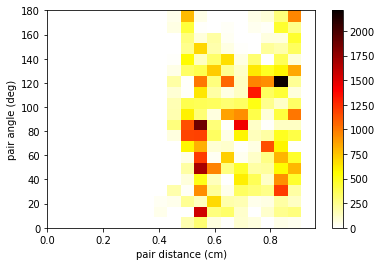

In [12]:
# Plot the joint distribution of pair distance and pair angle.
trial.group.collect_distance_alignment(ocut = True, 
                                       vcut = True, 
                                       wcut = True)
dist_align = np.copy(trial.group.dij_mij)
dist_align[:,1] = 180/np.pi*np.arccos(dist_align[:,1]) # convert to degrees

plt.hist2d(dist_align[:,0], dist_align[:,1], bins = [20,20], 
           range=[[0,2*trial.tank.r_cm],[0,180]], cmap=plt.cm.hot_r)
plt.xlabel("pair distance (cm)")
plt.ylabel("pair angle (deg)")
plt.colorbar()
# plt.savefig(trial.make_fig_file('pairs',tag),**trial.plot_options)
plt.show()
# plt.clf()

In [8]:
df.columns

Index(['t', 'x', 'y', 'theta', 'col', 'row', 'theta_pix', 'dwall', 'vx', 'vy',
       'speed', 'ax', 'ay', 'ex', 'ey', 'etheta', 'omega', 'alpha', 'af', 'al',
       'd_n0', 'm_n0', 'd_nn', 'ocut', 'vcut', 'wcut', 'cut'],
      dtype='object')

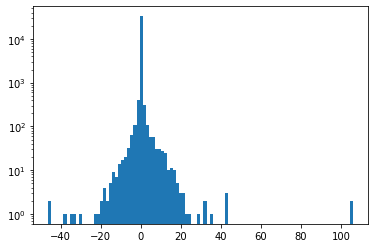

In [20]:
df = trial.group.fish[0].df
h,b = np.histogram(df['omega'].dropna(),bins=100)
x = (b[1:]+b[:-1])/2
# print(h.shape,b.shape,x.shape)
plt.bar(x,h,width=x[1]-x[0])
plt.yscale('log')
# plt.ylim(None,500)
plt.show()

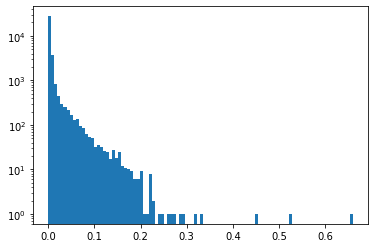

In [21]:
df = trial.group.fish[0].df
h,b = np.histogram(df['speed'].dropna(),bins=100)
x = (b[1:]+b[:-1])/2
# print(h.shape,b.shape,x.shape)
plt.bar(x,h,width=x[1]-x[0])
plt.yscale('log')
# plt.ylim(None,500)
plt.show()

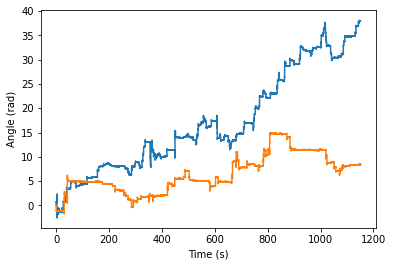

In [14]:
# %matplotlib notebook
%matplotlib inline

for f in trial.group.fish:
    t   = f.df['t']
    th  = f.df['theta']

    dth = th.diff()
    dth = dth - 2*np.pi*np.rint(dth/(2*np.pi))
    th  = np.cumsum(dth)

    I = (t>297) & (t<301)
    # t,th = t[I],th[I]

    # plt.figure(figsize=(12,6))
    # plt.xlim(297,301)
    plt.plot(t,th) #,marker='.')

plt.xlabel('Time (s)')
plt.ylabel('Angle (rad)')
plt.savefig(trial.make_fig_file('angle-vs-time',''),**trial.plot_options)
plt.show()